In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, auc, precision_score, recall_score

import os
os.chdir('E:/Data Science/Competitions/data/JantaHack_HR_Analytics')

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore',category= DataConversionWarning)
warnings.simplefilter(action='ignore',category=FutureWarning)

In [2]:
df = pd.read_csv('final_train.csv')

In [3]:
df.head()

,city_development_index,target,CT_Funded Startup,CT_NGO,CT_Other,CT_Public Sector,CT_Pvt Ltd,EL_High School,EL_Masters,EL_Phd,...,EU_Part time course,EU_no_enrollment,G_Male,G_Other,RE_No relevent experience,EL_mid,EL_no,EL_senior,CS_mid,CS_small
0,0.689,0,0,0,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
1,0.923,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,1
2,0.910,0,0,0,0,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
3,0.666,0,0,0,0,0,1,0,0,0,...,0,1,1,0,0,1,0,0,0,1
4,0.887,1,0,0,0,0,1,0,1,0,...,0,1,1,0,1,0,0,0,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18359 entries, 0 to 18358
Data columns (total 21 columns):
city_development_index       18359 non-null float64
target                       18359 non-null int64
CT_Funded Startup            18359 non-null int64
CT_NGO                       18359 non-null int64
CT_Other                     18359 non-null int64
CT_Public Sector             18359 non-null int64
CT_Pvt Ltd                   18359 non-null int64
EL_High School               18359 non-null int64
EL_Masters                   18359 non-null int64
EL_Phd                       18359 non-null int64
EL_Primary School            18359 non-null int64
EU_Part time course          18359 non-null int64
EU_no_enrollment             18359 non-null int64
G_Male                       18359 non-null int64
G_Other                      18359 non-null int64
RE_No relevent experience    18359 non-null int64
EL_mid                       18359 non-null int64
EL_no                        18359 non-

In [5]:
df['target'].value_counts()

0    15934
1     2425
Name: target, dtype: int64

In [6]:
df.shape

(18359, 21)

## Custom Functions

In [7]:
# train test split
def perform_train_test_split(x,y,size):
    return train_test_split(x, y, test_size = size, random_state = 0)

# function for scaling the data for train test split
def std_data(xtrain,xtest):
    sc = StandardScaler()
    scaled = sc.fit(xtrain)
    scaled_train = sc.transform(xtrain)
    scaled_test = sc.transform(xtest)
    return scaled_train, scaled_test

# function to scale whole data
def std_all_data(x):
    sc = StandardScaler()
    scaled = sc.fit_transform(x)
    return scaled
    
# function for applying random search cv
def random_search_cv(x,y,model,params):
    RS = RandomizedSearchCV(model, params, cv = 5, scoring = 'roc_auc', random_state = 0)
    RS.fit(x,y)
    return RS.best_params_, RS.best_estimator_, RS.best_score_

# function for applying grid search cv
def grid_search_cv(x,y,model,params):
    GS = GridSearchCV(model, params, cv = 5, scoring = 'roc_auc')
    GS.fit(x,y)
    return GS.best_params_

# creating an empty dataframe with headers
headers=['AUC Train','AUC Test','Acc Train','Acc Test']
dfObj = pd.DataFrame(columns = headers)


# function to get roc_auc_scores for train and test  
def fit_predict_plot(xtrain,xtest,ytrain,ytest,models):
    
    for name, model in models:
        
        model.fit(xtrain,ytrain)
        
        y_pred_train = model.predict(xtrain)
        y_pred_test = model.predict(xtest)
        
        probas_train = model.predict_proba(xtrain)[:,1]
        probas_test = model.predict_proba(xtest)[:,1]

        model_name = name 
        
        plot_roc_auc_curve(probas_train,probas_test,ytrain,ytest,name)
        
        return get_metrics(ytrain,ytest,y_pred_train,y_pred_test,probas_train,probas_test,model_name)
    
    
# function to plot the roc auc curve
def plot_roc_auc_curve(probas_train,probas_test,y_train,y_test,name):
    
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train,probas_train)

        fpr_test, tpr_test, thresholds_test = roc_curve(y_test,probas_test)

        
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
        plt.plot(fpr_train, tpr_train, color='b', 
                 label=r'Train ROC (AUC = %0.2f )' % (roc_auc_score(y_train,probas_train)),lw=2, alpha=.5)
        plt.plot(fpr_test, tpr_test, color='g', 
                 label=r'Test ROC (AUC = %0.2f )' % (roc_auc_score(y_test,probas_test)),lw=2, alpha=.8)

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate',fontsize=10)
        plt.ylabel('True Positive Rate',fontsize=10)
        plt.title('ROC of %s' % (name),fontsize=10)
        plt.legend(loc="lower right", prop={'size': 9})
        plt.show()

        

    
# function to get all other metrics
def get_metrics(y_train,y_test,y_pred_train,y_pred_test,probas_train,probas_test,name):
        global dfObj
        print('Confusion Matrix:\n')
        print('For Train Data:\n')
        print(confusion_matrix(y_train,y_pred_train))
        #print('Classification Report:\n',classification_report(y_train,y_pred_train))
        
        print('\n For Test Data:\n')
        print(confusion_matrix(y_test,y_pred_test))
        #print('Classification Report:\n',classification_report(y_test,y_pred_test))

        dfObj.loc[name] = [roc_auc_score(y_train,probas_train), roc_auc_score(y_test,probas_test),
                           accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test),
                        ]
        return dfObj
        

# function for applying various models
def implement_cv(x,y,models):
    final = {}
    results = []
    names = []
    auc = []
    for name,model in models:
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        cv_results = model_selection.cross_val_score(model,x,y,cv=kfold, scoring='roc_auc')
        results.append((np.abs(cv_results)))
        auc.append(np.mean(results))
        names.append(name)
        
        print('Test Scores for {}:\n'.format(name),cv_results)
        final.update({'Model': names , 'roc_auc_score': auc})
    return pd.DataFrame(final)



In [8]:
X =  df.drop('target', axis = 1)
Y = df['target']

In [9]:
LOGR = LogisticRegression(random_state = 0)
DT = DecisionTreeClassifier(random_state = 0)
RF = RandomForestClassifier(random_state = 0)
GB = GradientBoostingClassifier(random_state = 0)
XGB = XGBClassifier(random_state = 0)

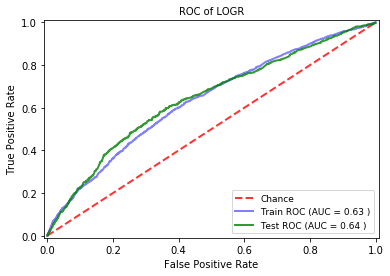

Confusion Matrix:

For Train Data:

[[11184     0]
 [ 1667     0]]

 For Test Data:

[[4750    0]
 [ 758    0]]


,AUC Train,AUC Test,Acc Train,Acc Test
LOGR,0.633728,0.641715,0.870282,0.862382


In [10]:
X_train,X_test,y_train,y_test = perform_train_test_split(X,Y,0.3)

models = [('LOGR',LOGR)]
fit_predict_plot(X_train,X_test,y_train,y_test,models)

### Now, as there is class imbalance in the data, this has to be treated using SMOTE Analysis

## Oversampling using SMOTE

In [11]:
import imblearn

In [12]:
# transform the dataset
oversample = imblearn.over_sampling.SMOTE(sampling_strategy=0.8)
X_smote, y= oversample.fit_resample(X, Y)

y.value_counts()

0    15934
1    12747
Name: target, dtype: int64

#### After oversampling, we have enough data for the minority class. Now, we can build models upon this new dataset

### Models after SMOTE

In [13]:
X = X_smote
Y = y

In [14]:
X_train,X_test,y_train,y_test = perform_train_test_split(X,Y,0.3)

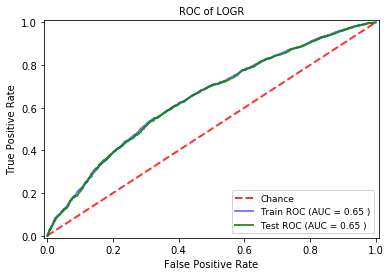

Confusion Matrix:

For Train Data:

[[8681 2473]
 [5192 3730]]

 For Test Data:

[[3702 1078]
 [2216 1609]]


,AUC Train,AUC Test,Acc Train,Acc Test
LOGR,0.646833,0.645051,0.618201,0.617199


In [15]:
models = [('LOGR',LOGR)]
fit_predict_plot(X_train,X_test,y_train,y_test,models)

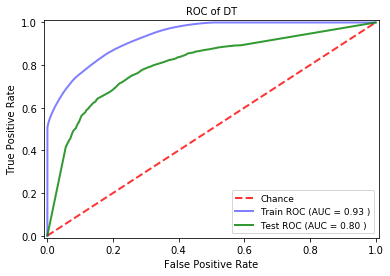

Confusion Matrix:

For Train Data:

[[10114  1040]
 [ 2218  6704]]

 For Test Data:

[[4003  777]
 [1334 2491]]


,AUC Train,AUC Test,Acc Train,Acc Test
LOGR,0.646833,0.645051,0.618201,0.617199
DT,0.934039,0.804982,0.837717,0.754678


In [16]:
models = [('DT',DT)]
fit_predict_plot(X_train,X_test,y_train,y_test,models)

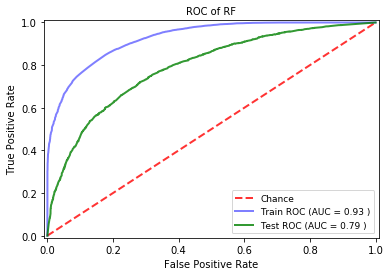

Confusion Matrix:

For Train Data:

[[9990 1164]
 [2094 6828]]

 For Test Data:

[[3870  910]
 [1488 2337]]


,AUC Train,AUC Test,Acc Train,Acc Test
LOGR,0.646833,0.645051,0.618201,0.617199
DT,0.934039,0.804982,0.837717,0.754678
RF,0.926732,0.790312,0.837717,0.721325


In [17]:
models = [('RF',RF)]
fit_predict_plot(X_train,X_test,y_train,y_test,models)

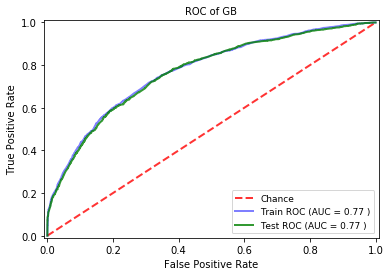

Confusion Matrix:

For Train Data:

[[9216 1938]
 [3877 5045]]

 For Test Data:

[[3920  860]
 [1665 2160]]


,AUC Train,AUC Test,Acc Train,Acc Test
LOGR,0.646833,0.645051,0.618201,0.617199
DT,0.934039,0.804982,0.837717,0.754678
RF,0.926732,0.790312,0.837717,0.721325
GB,0.772302,0.768158,0.710351,0.706566


In [18]:
models = [('GB',GB)]
fit_predict_plot(X_train,X_test,y_train,y_test,models)

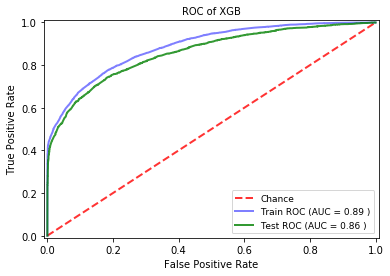

Confusion Matrix:

For Train Data:

[[9950 1204]
 [2770 6152]]

 For Test Data:

[[4180  600]
 [1249 2576]]


,AUC Train,AUC Test,Acc Train,Acc Test
LOGR,0.646833,0.645051,0.618201,0.617199
DT,0.934039,0.804982,0.837717,0.754678
RF,0.926732,0.790312,0.837717,0.721325
GB,0.772302,0.768158,0.710351,0.706566
XGB,0.886669,0.859022,0.802052,0.785125


In [19]:
models = [('XGB',XGB)]
fit_predict_plot(X_train,X_test,y_train,y_test,models)

#### Here, the models were built using train test split considering evaluation metric as ROC AUC score.

#### From all the models built, the XGBoost models perfroms better on the test data with ROC AUC Score of 85% and does not overfit or underfit.

#### The performance of models could be improved by hyperparameter tuning.

## Evaluating the XGB Model using 5-fold cross validation

In [20]:
def evaluate_model(x,y,models):
    
    for name,model in models:
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        cv_results = model_selection.cross_validate(model,x,y,cv=kfold, scoring='roc_auc',return_train_score = True)
        train_cv_score = [i for i in cv_results['train_score']]
        test_cv_score = [i for i in cv_results['test_score']]
        print('For {} model:\n'.format(name))
        print('Train Scores: ',train_cv_score)
        print('Test Scores: ',test_cv_score)
        print('Mean Train Scores: ', np.mean(train_cv_score))
        print('Mean Test Scores: ', np.mean(test_cv_score))
        
        #plt.figure(figsize = (5,5))
        #plt.ylim([0,100])
        #plt.plot(np.arange(1,6,1),train_cv_score, label=r'Train Mean %0.2f )' % (np.mean(train_cv_score)),lw=2, alpha=.5)
        #plt.plot(np.arange(1,6,1),test_cv_score, label=r'Test Mean %0.2f )' % (np.mean(test_cv_score)),lw=2, alpha=.5)
        #plt.legend(loc="best", prop={'size': 9})
        #plt.show()

In [21]:
models = [('XGB',XGB)]
evaluate_model(X,Y,models)

For XGB model:

Train Scores:  [0.8876041245710422, 0.8877299134381746, 0.8884631287168393, 0.8878568808801651, 0.8866316487463362]
Test Scores:  [0.8623589928085841, 0.8625470773342183, 0.8558564468515748, 0.8491028466125625, 0.859789664998188]
Mean Train Scores:  0.8876571392705115
Mean Test Scores:  0.8579310057210255


## Predicting the class using test set

In [23]:
test_data = pd.read_csv('final_test.csv')

In [24]:
y_pred = XGB.predict(test_data)

In [25]:
print(y_pred)

[1 0 1 ... 0 0 1]
